In [172]:
import csv
import numpy as np

images, labels = [], []

with open('train.csv') as train_file:
    # Skip first line.
    train_file.readline()
    
    csv_train_file = csv.reader(train_file, delimiter=',')
    for row in csv_train_file:
        labels.append(row[0])
        images.append(np.array(row[1:], dtype=float))

In [173]:
##############################################################
#           Part One: Preprocess Data 1) Explore
##############################################################

Printing sample with label 8.


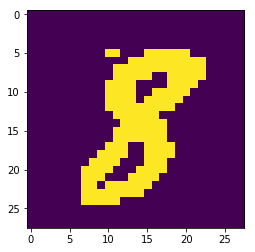

In [174]:
sample_index = 20

import matplotlib
from matplotlib import pyplot as plt

sample, label = images[sample_index], labels[sample_index]
plt.imshow(np.reshape(sample, (28, 28)), norm=matplotlib.colors.NoNorm())

print("Printing sample with label %s." % (label))
plt.show()

Printing sample with normalzied pixels.


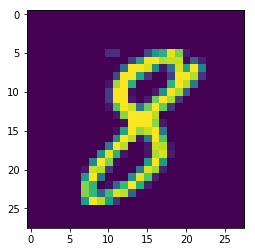

In [175]:
# Normalizing a sample to scale of (0, 1)

PIXEL_SCALE = 255
normalized_sample = sample / PIXEL_SCALE
plt.imshow(np.reshape(normalized_sample, (28, 28)), norm=matplotlib.colors.NoNorm())
print("Printing sample with normalzied pixels.")
plt.show()

In [176]:
normalized_images = [image / PIXEL_SCALE for image in images]

In [177]:
################################################################
#           Part One: Preprocess Data 2) Split Data Set
################################################################

In [178]:
# One hot encoding labels.
def one_hot_label(label):
    one_hot_coded = np.zeros(10)
    one_hot_coded[int(label)] = 1
    return np.array(one_hot_coded)

In [206]:
import random

combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

validation_size = int(len(images) / 10)

validate_images = [np.array(image).reshape((28, 28, 1)) for image in images[:validation_size]]
validate_labels = [one_hot_label(label) for label in labels[:validation_size]]

images = images[validation_size:]
labels = labels[validation_size:]


In [207]:
import tensorflow as tf

In [208]:
################################################################
#                Part Two: (1) Create Tensor
################################################################

In [227]:
def conv_net_input(input_shape):
    tensor_shape = [None] + list(input_shape)
    return tf.placeholder(tf.float32, shape=tensor_shape, name='conv_input')

def conv_net_label(label_shape):
    label_shape = [None, label_shape]
    return tf.placeholder(tf.float32, shape=label_shape, name='conv_label')

def conv_net_dropout_prob():
    return tf.placeholder(tf.float32, name='dropout_prob')

In [228]:
##############################################################
#                Part Two: (2) Create Layer
##############################################################

In [229]:
def conv2d(input_tensor, kernel_depth=1, output_dim=32, k_size=3, padding='valid'):
    """
    :param input_tensor: input tensor, should be reshaped to 2D
    :param output_dim: output dimension, e.g. 32, 64, etc. 
    :param kernel_size: kernel size, 3, 5, etc.
    """
    conv_layer = tf.layers.conv2d(input_tensor,
                                  output_dim,
                                  k_size,
                                  padding=padding,
                                  activation=tf.nn.relu)
    
    return conv_layer

In [230]:
def max_pool(input_tensor, pool_ksize, pool_strides, padding='valid'):
    return tf.layers.max_pooling2d(
        input_tensor,
        pool_ksize,
        pool_strides,
        padding
    )

In [231]:
from functools import reduce

def flatten(input_tensor):
    image_dimension = reduce(lambda a,b: a*b, input_tensor.get_shape().as_list()[1:])    
    return tf.reshape(input_tensor, [-1, image_dimension])

In [232]:
def fully_connected_with_dropout(input_tensor, output_dim, dropout):    
    fully_connected = tf.layers.dense(
        input_tensor,
        output_dim,
    )
    
    dropout_layer = tf.layers.dropout(inputs=fully_connected, rate=dropout)    
    
    return dropout_layer

In [233]:
def output_layer(input_tensor, output_dim):    
    return tf.layers.dense(
        input_tensor,
        output_dim,
    )

In [234]:
class BatchLoader:
    
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.offset = 0
        
    def load_batch(self, batch_size):        
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]
                
        label_batch = self.labels[i: i + batch_size]
        label_batch = [one_hot_label(label) for label in label_batch]
        self.offset += batch_size
                
        return image_batch, label_batch
        
    def reset(self):
        self.offset = 0

In [235]:
##############################################################
#                Part Two: (3) Create Model
##############################################################

In [236]:
def conv_net(image, dropout_prob):
    """
    :param image: input image tensor.
    :dropout_prob: drop out probability.
    """
    # convolution - max pooling layer 1
    conv_layer = conv2d(image, kernel_depth=1, output_dim=16, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 2
    conv_layer = conv2d(mp_layer, kernel_depth=16, output_dim=32, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 3
    conv_layer = conv2d(mp_layer, kernel_depth=32, output_dim=64, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    flat = flatten(mp_layer)
    
    # def fully_connected_with_dropout(input_tensor, output_dim, dropout):
    
    fully_conn = fully_connected_with_dropout(flat, 96, dropout_prob) 
    logits = output_layer(fully_conn, 10)
    
    return logits

In [237]:
##############################################################
#                Part Three: Define Loss & Accuracy
##############################################################

In [238]:
tf.reset_default_graph()

image_tensor = conv_net_input((28, 28, 1))
label_tensor = conv_net_label(10)
dropout_prob_tensor = conv_net_dropout_prob()

# Module

logits = conv_net(image_tensor, dropout_prob_tensor)

# Loss & Optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(label_tensor, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [239]:
from functools import reduce
reduce((lambda a,b: a*b), [1,2], 1)

2

In [240]:
def print_stats(session, image_batch, label_batch, t_type='Training'):
#     print('label_batch: ', label_batch)
    
    _loss = session.run(loss, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0
    })

    _accuracy = session.run(accuracy, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    _logits = session.run(logits, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    _match = session.run(correct_pred, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    print(t_type + ' loss: ', _loss)
    print(t_type + ' accuracy: ', _accuracy)
#     print('true labels: ', np.argmax(label_batch, axis=1))
#     print('predicted labels ', np.argmax(_logits, axis=1))



In [241]:
##############################################################
#                Part Four: Training
##############################################################

In [242]:
def train_model(session, optimizer, image_batch, label_batch, dropout_prob):
    
#     print('image_batch shape: ', len(image_batch))
#     print('label_batch shape: ', len(label_batch))
#     print('dropout_prob shape: ', dropout_prob)
    
    session.run(
        optimizer,
        feed_dict={
            image_tensor : image_batch,
            label_tensor : label_batch,
            dropout_prob_tensor : dropout_prob
        }
    )

In [250]:
def run_model(epochs, images, labels, batch_size, dropout_prob):
    
    with tf.Session() as session:
        
        # Initializing the variables
        session.run(tf.global_variables_initializer())
    
        # Prepare batches for images & labels
        loader = BatchLoader(images, labels)
    
        for epoch in range(epochs):
            loader.reset()
            
            count = 0
            
            while True:                
                image_batch, label_batch = loader.load_batch(batch_size)
                count += 1
                
                # Process each batch.
                if len(image_batch) != 0  and len(label_batch) != 0:                     
                    train_model(session, optimizer, image_batch, label_batch, dropout_prob)
                    
                    # Print stats every 20 epochs.
                    if count % 20 == 0:
                        print('===============epoch: ', epoch, '=================')
                        print_stats(session, image_batch, label_batch) 
                        print_stats(session, validate_images, validate_labels, t_type='Validate') 
                else:
                    break


In [251]:
run_model(100, images, labels, 600, 0.3)

===============epoch:  0 =================
Training loss:  2.25588
Training accuracy:  0.505
Validate loss:  2.34835
Validate accuracy:  0.472958
===============epoch:  0 =================
Training loss:  1.00664
Training accuracy:  0.693333
Validate loss:  1.02597
Validate accuracy:  0.698004
===============epoch:  1 =================
Training loss:  0.618909
Training accuracy:  0.821667
Validate loss:  0.683807
Validate accuracy:  0.801815
===============epoch:  1 =================
Training loss:  0.536786
Training accuracy:  0.838333
Validate loss:  0.544986
Validate accuracy:  0.836661
===============epoch:  2 =================
Training loss:  0.387137
Training accuracy:  0.893333
Validate loss:  0.454568
Validate accuracy:  0.867514
===============epoch:  2 =================
Training loss:  0.369853
Training accuracy:  0.88
Validate loss:  0.394009
Validate accuracy:  0.888203
===============epoch:  3 =================
Training loss:  0.280276
Training accuracy:  0.906667
Validate

In [ ]:
print(len(images))
print(len(labels))